In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import random


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

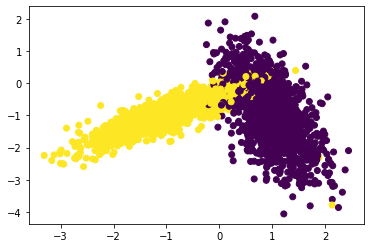

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [3]:
def grouping_train_data_on_fold(x_train,groupSize):
    
    #x_train - ndim_array
    #groupSize - no of folds
    
    #return Dictionary As key GroupNumber and Value as Indexes
    
    #Example when x_train length is 10 and group size is 3 return {3:[0,1,2],2:[3,4,5],1:[6,7,8,9]}
    
    #Generating Index for Length of the train Data
    
    train_index = [idx for idx in range(0,len(x_train))]
    
    groupNumberSize = groupSize
    
    group_data_size = 0

    group_data_dict = {}
    
    
    while(groupNumberSize > 0):
    
        #compute the lenght of the index of the train_data
        length_of_x_train_index = len(train_index)
         
        #compute the length of data split based on the split of Each Group
        group_data_size = length_of_x_train_index // groupNumberSize
   
        #group_data_list Store the list of indexes based on group size
        group_data_list = train_index[:group_data_size]
        
        #Store the data index key as fold number and value as index
        group_data_dict[groupNumberSize] = group_data_list
        
        #update the original index_Value
        train_index = train_index[group_data_size:]
        
        groupNumberSize -= 1
        
    return group_data_dict


def generate_random_k(param_range):
    
    random_k_list = []
    #Generate random unique Value
    random_k_list = random.sample(param_range,10)
    
    return random_k_list


def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    
    trainScores = []
    
    testScores = []
    
    #Genereating 10 Random Unique K Stored in Param
    param = generate_random_k(param_range)
    
    #Sort the param in ascending Order,Because K is generated Randomly so we sort the param
    param.sort()
    
    #grouping the training_data Based On Folds
    grouping_Indexes = grouping_train_data_on_fold(x_train,folds)
    
    #iterate the K
    for k in param:
        
        train_cv_score = []
        
        test_cv_score = []
        
        #iterate the folds
        for fold in range(1,folds + 1):
            
            train_indices = []
            
            test_indices = []
            
            #if the fold is 1 store the 
            for key,value in grouping_Indexes.items():
                
                #key is equal to fold take the index as testindices and rest of them is considered as trainIndices
                if key == fold:
                    
                    test_indices.extend(value)
                else:
                    train_indices.extend(value)
                    
            X_train = x_train[train_indices]
            
            Y_train = y_train[train_indices]
            
            X_test  = x_train[test_indices]
            
            Y_test  = y_train[test_indices]
            
            classifier.n_neighbors = k
            
            classifier.fit(X_train,Y_train)
            
            predict = classifier.predict(X_test)
            
            test_cv_score.append(accuracy_score(Y_test, predict))
            
            Y_predicted = classifier.predict(X_train)
            
            train_cv_score.append(accuracy_score(Y_train, Y_predicted))
            
        trainScores.append(np.mean(np.array(train_cv_score)))
        
        testScores.append(np.mean(np.array(test_cv_score)))
        
    return [trainScores,testScores,param]

Randomly Generated k :[3, 4, 13, 14, 20, 23, 31, 37, 42, 45]


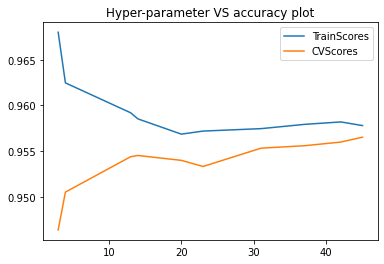

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()
folds = 3
#param_range from 1 to 50
param_range = range(1,50)

trainscores,cv_scores,params = RandomSearchCV(X_train, y_train, neigh,param_range , folds)

print("Randomly Generated k :{0}".format(params))
print("="*100)

plt.plot(params,trainscores, label='TrainScores')
plt.plot(params,cv_scores, label='CVScores')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

Observation

Doing HyperParameter Tuning Using RandomSearchCV with 10 unique k, with 3 fold Cross Validation,Observing K = 45 has Good accuracy for the for training and test phase.45 is the best hyperparameter  for KNN Model

In [5]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

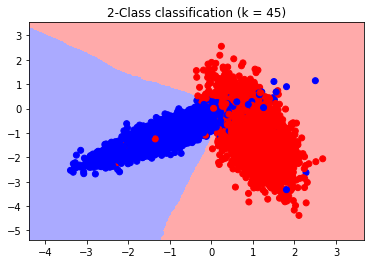

In [7]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors =45)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)